## INTRODUCTION

Loan lending is a profitable and viable business which most investors have invested a lot of their money in and returned hundsome interests. Loans are advanced for a number of reasons including major purchases, investing, renovations, debt consolidation, and business ventures. The interest and fees from loans are primary source of revenue for many banks and some retailers through the use of credit facilities and credit card. However, the success of a loan company is highly dependent on wether a client will default or not. Therefore, it is important to have prior knowledge as to wether the client likely to default or not. Due this, it was found to be important to develop a prediction model that utilises deep learning to detect wether a client will default or not. In this project, using the historical data from 2007 to 2015 of a company called Lending club, a deep learning model was built to predict the chance of default for future loans. 

This data was comprised of the following features:
credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.

- ***purpose***: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").

- ***int.rate***: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.

- ***installment***: The monthly installments owed by the borrower if the loan is funded.

- ***log.annual.inc***: The natural log of the self-reported annual income of the borrower.

- ***dti***: The debt-to-income ratio of the borrower (amount of debt divided by annual income).

- ***fico***: The FICO credit score of the borrower.

- ***days.with.cr.line***: The number of days the borrower has had a credit line.

- ***revol.bal***: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).

- ***revol.util***: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).

- ***inq.last.6mths***: The borrower's number of inquiries by creditors in the last 6 months.

- ***delinq.2yrs***: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.

- ***pub.rec***: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

 

## IMPORT RELEVANT LIBRARIES

In [98]:
# Data loading and data management
import pandas as pd
import numpy as np

# Data exploration
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, norm

# Data wrangling and feature engineering
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder

# Deep learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
import keras_tuner as kt

## DATA LOADING AND INSPECTION

In [21]:
# Read data
data = pd.read_csv("loan_data.csv")

In [22]:
# Check the first five variables of the dataframe
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [23]:
# Check the size of the dataframe
data.shape

(9578, 14)

In [24]:
# See the data types of variables in the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [25]:
# Check the target variable
data['not.fully.paid'].value_counts()

0    8045
1    1533
Name: not.fully.paid, dtype: int64

In [26]:
#handling imbalanced dataset
not_fully_paid_0 = data[data['not.fully.paid'] == 0]
not_fully_paid_1 = data[data['not.fully.paid'] == 1]

print('not_fully_paid_0', not_fully_paid_0.shape)
print('not_fully_paid_1', not_fully_paid_1.shape)

not_fully_paid_0 (8045, 14)
not_fully_paid_1 (1533, 14)


In [27]:
#handling imbalanced data
from sklearn.utils import resample
df_minority_upsampled = resample(not_fully_paid_1, replace = True, n_samples = 8045)
df = pd.concat([not_fully_paid_0, df_minority_upsampled])

from sklearn.utils import shuffle
df = shuffle(df)

In [28]:
#imbalanced data handled
df['not.fully.paid'].value_counts()  

0    8045
1    8045
Name: not.fully.paid, dtype: int64

The data contained contained in the dataframe is comprised of float64, int64 and object values.

In [29]:
# Separate data to include numerical data only
num_data = df[["int.rate", "installment", "log.annual.inc", "dti", "fico", "days.with.cr.line", "revol.bal", 
               "revol.util", "not.fully.paid"]]
num_data

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,not.fully.paid
4037,0.1695,356.27,10.839581,23.53,702,4410.000000,19230,44.4,0
679,0.1640,636.39,11.918391,24.03,672,4290.041667,28846,57.9,1
3921,0.1758,251.60,10.308953,13.16,712,2100.000000,12017,73.7,0
694,0.1071,782.44,11.156251,0.57,727,5040.041667,782,3.0,1
5404,0.0894,292.30,11.127263,17.81,752,9300.000000,38581,65.4,0
...,...,...,...,...,...,...,...,...,...
9161,0.1411,51.35,10.463218,6.10,677,1440.000000,5247,47.1,0
2464,0.1442,302.57,10.742811,5.94,707,4379.958333,8134,80.2,0
4100,0.1568,875.04,11.589887,15.73,682,3570.000000,36015,88.5,1
395,0.0920,306.18,11.034890,13.12,742,5250.041667,24406,40.3,1


In [30]:
# Check the features in the numerical data
num_data_features = num_data.columns
num_data_features

Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'not.fully.paid'],
      dtype='object')

In [31]:
# Separate data to include categorical data only
cat_data = df[["credit.policy", "purpose", "inq.last.6mths", "delinq.2yrs", "not.fully.paid"]]
cat_data

,credit.policy,purpose,inq.last.6mths,delinq.2yrs,not.fully.paid
4037,1,small_business,3,0,0
679,1,credit_card,1,0,1
3921,1,small_business,1,0,0
694,1,all_other,1,0,1
5404,1,debt_consolidation,1,0,0
...,...,...,...,...,...
9161,0,debt_consolidation,5,0,0
2464,1,debt_consolidation,0,0,0
4100,1,debt_consolidation,1,0,1
395,1,credit_card,1,0,1


In [32]:
# Check the features in the numerical data
cat_data_features = cat_data.columns
cat_data_features

Index(['credit.policy', 'purpose', 'inq.last.6mths', 'delinq.2yrs',
       'not.fully.paid'],
      dtype='object')

## DATA EXPLORATION

An exploration of the numerical data will be given below and this will include statistical analysis such as the identification of standards deviations and central tendecies, the quantiles and minimums and maximums of data variables.

In [33]:
# Check the statistics of the numerical data
num_data.describe()

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,not.fully.paid
count,16090.000000,16090.000000,16090.000000,16090.000000,16090.000000,16090.000000,1.609000e+04,16090.000000,16090.000000
mean,0.126576,328.333449,10.914849,12.881747,705.582971,4496.125344,1.877860e+04,49.103687,0.500000
std,0.026803,215.258550,0.645694,6.959208,37.008273,2489.067559,4.362815e+04,29.081985,0.500016
min,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000
25%,0.110300,165.670000,10.518727,7.390000,677.000000,2789.958333,3.279250e+03,25.500000,0.000000
50%,0.126100,275.105000,10.915088,13.020000,702.000000,4080.000000,8.752500e+03,49.800000,0.500000
75%,0.143800,464.170000,11.289782,18.380000,732.000000,5699.958333,1.935050e+04,73.400000,1.000000
max,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,1.000000


***Summary of the statistical data above***

- The feature ***revol.bal*** (The borrower's revolving line utilization rate) has the highest standard deviation and so, it expected that this variable will contain outliers.
- Other features such as ***days.with.cr.line***, ***installment***, ***fico***, and ***revol.util*** also show high standard deviations, as such, outliers in this data have to be detect and handled.
- The highest number of days the borrower has had a credit line (***days.with.cr.line***) was 17640 days.

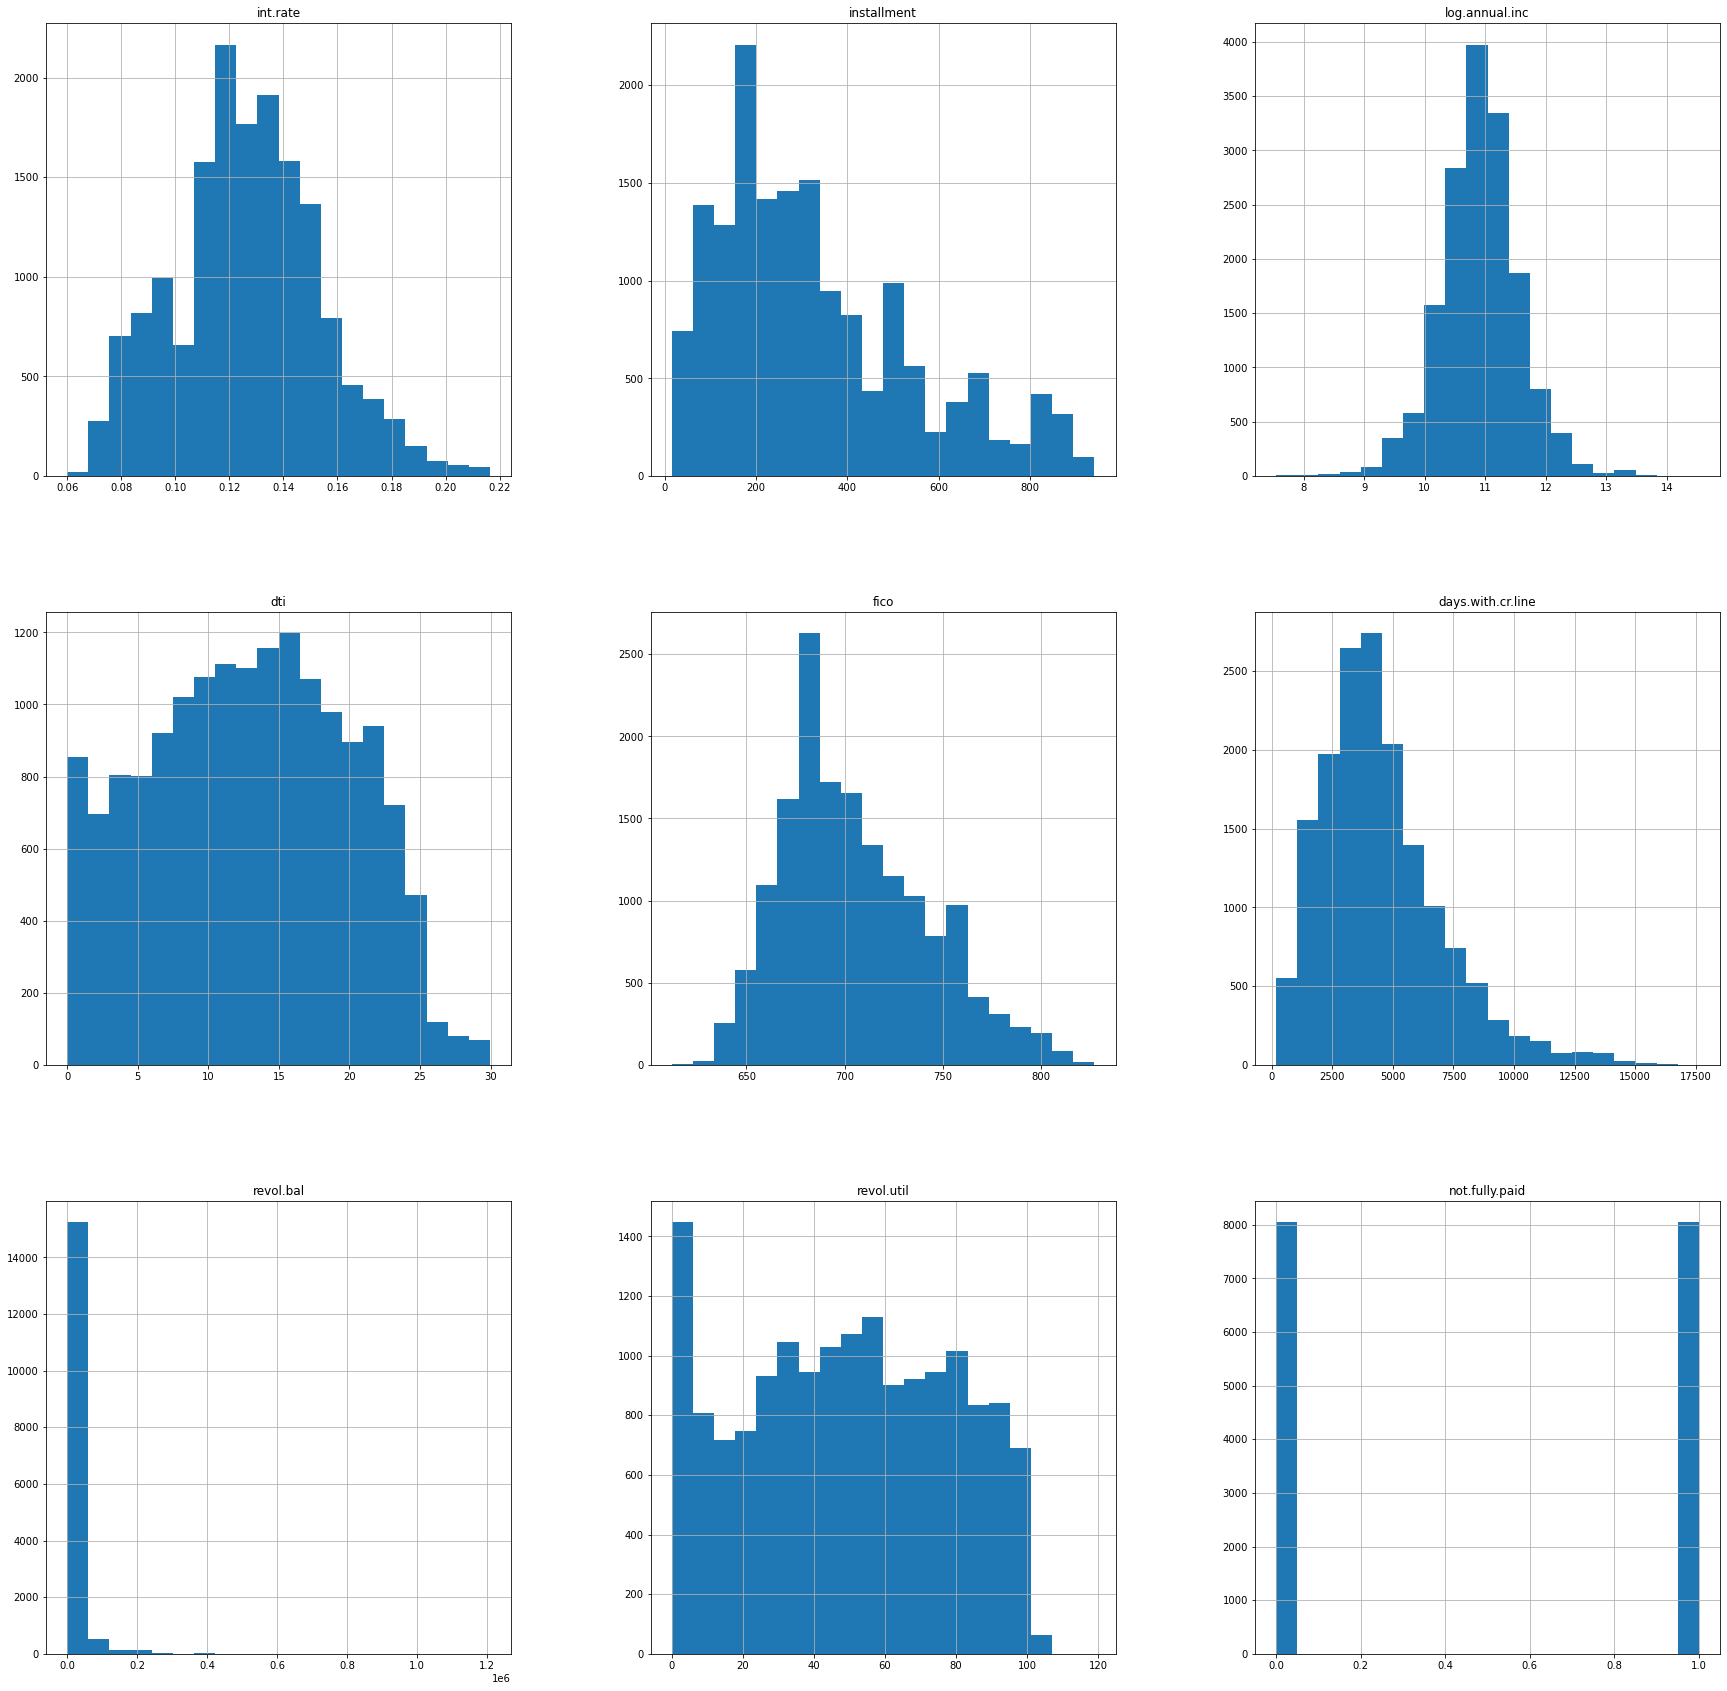

In [34]:
# Check the distribution of the numerical continous data
num_data.hist(figsize = (30, 30), bins = 20, legend = False)
plt.show()

The figures above comfirm the discussion given above that the variables such as ***revol.bal***, ***days.with.cr.line***, ***installment***, ***fico***, and ***revol.util*** may contain outliers because they are all positively skewed.

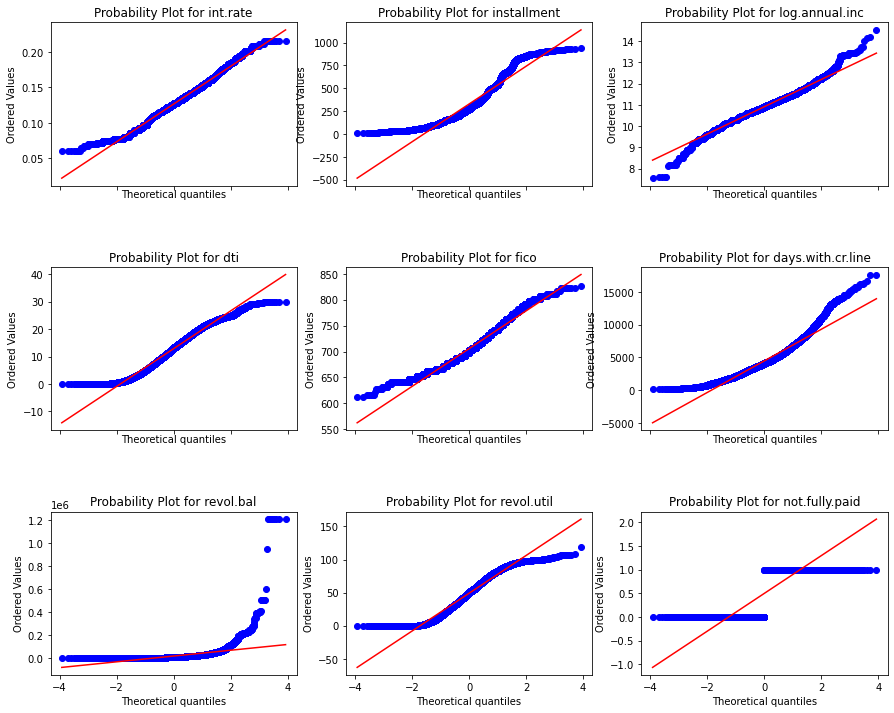

In [35]:
# Develop a probability plot to find out how compacted or degress of normalisation the data is.

# Define subplot grid
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 12), sharex = True)
fig.subplots_adjust(hspace = 0.5)


for i, col in enumerate(num_data):
    ax = plt.subplot(3, 3, i+1)
    stats.probplot(num_data[col], plot = ax)
    ax.set_title(f"Probability Plot for {col}")

Yet again it can be seen that the variables such as ***revol.bal***, ***days.with.cr.line***, ***installment***, ***fico***, and ***revol.util*** may contain outliers because the values in these variables do not fall well around the best fit line.

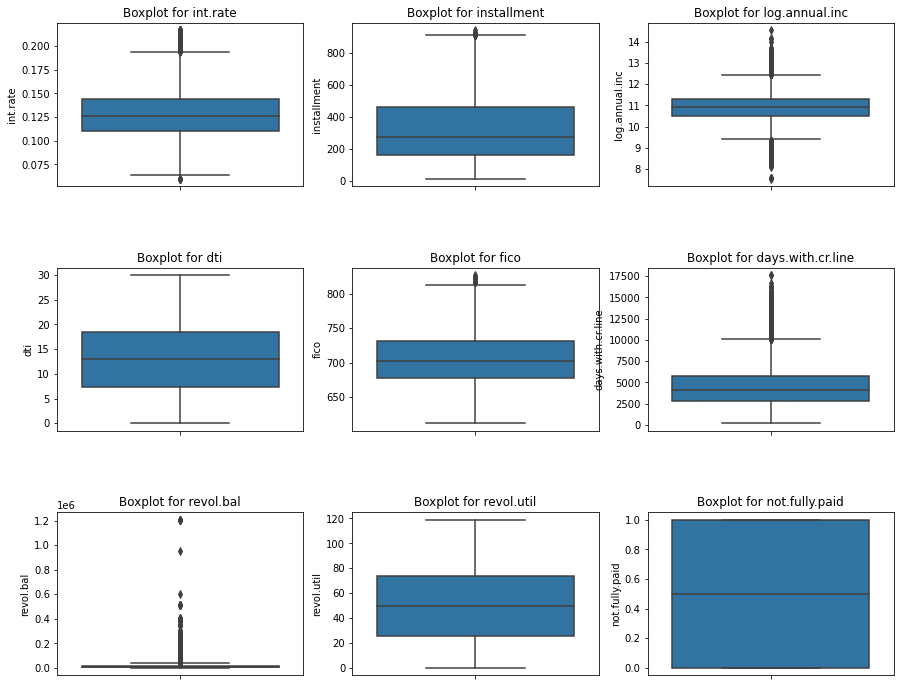

In [36]:
# Create plots showing the uncertainity in the data and the outliers.

# Define subplot grid
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 12), sharex = True)
fig.subplots_adjust(hspace = 0.5)


for i, col in enumerate(num_data):
    ax = plt.subplot(3, 3, i+1)
    sns.boxplot(y = df[col])
    ax.set_title(f"Boxplot for {col}")
plt.show()

From the graphs above, it can be seen that the outliers exist in the variables such as the following: ***int.rate***, ***installment***, ***log.annual.inc***, ***fico***, ***days.with.cr.line*** and ***revol.bal***. These outliers will be handles later.

***Below is an analysis of the categorical data***

In [38]:
# Converting categorical feature into numerical feature
cat_data = cat_data.copy()
le = preprocessing.LabelEncoder()
cat_data["purpose"] = le.fit_transform(cat_data["purpose"].astype(str))
cat_data.head()

,credit.policy,purpose,inq.last.6mths,delinq.2yrs,not.fully.paid
4037,1,6,3,0,0
679,1,1,1,0,1
3921,1,6,1,0,0
694,1,0,1,0,1
5404,1,2,1,0,0


In [39]:
# Check the statistics of the numerical data
cat_data.describe()

,credit.policy,purpose,inq.last.6mths,delinq.2yrs,not.fully.paid
count,16090.000000,16090.000000,16090.000000,16090.000000,16090.000000
mean,0.745494,2.014357,1.877315,0.163393,0.500000
std,0.435597,1.758665,2.592317,0.528946,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,1.000000,0.000000,0.500000
75%,1.000000,2.000000,3.000000,0.000000,1.000000
max,1.000000,6.000000,33.000000,13.000000,1.000000


The standard deviation in all the variables is small because the data ranges from either 0 to 1 and 0 to 6 or 0 to 33 and 0 to 13. 

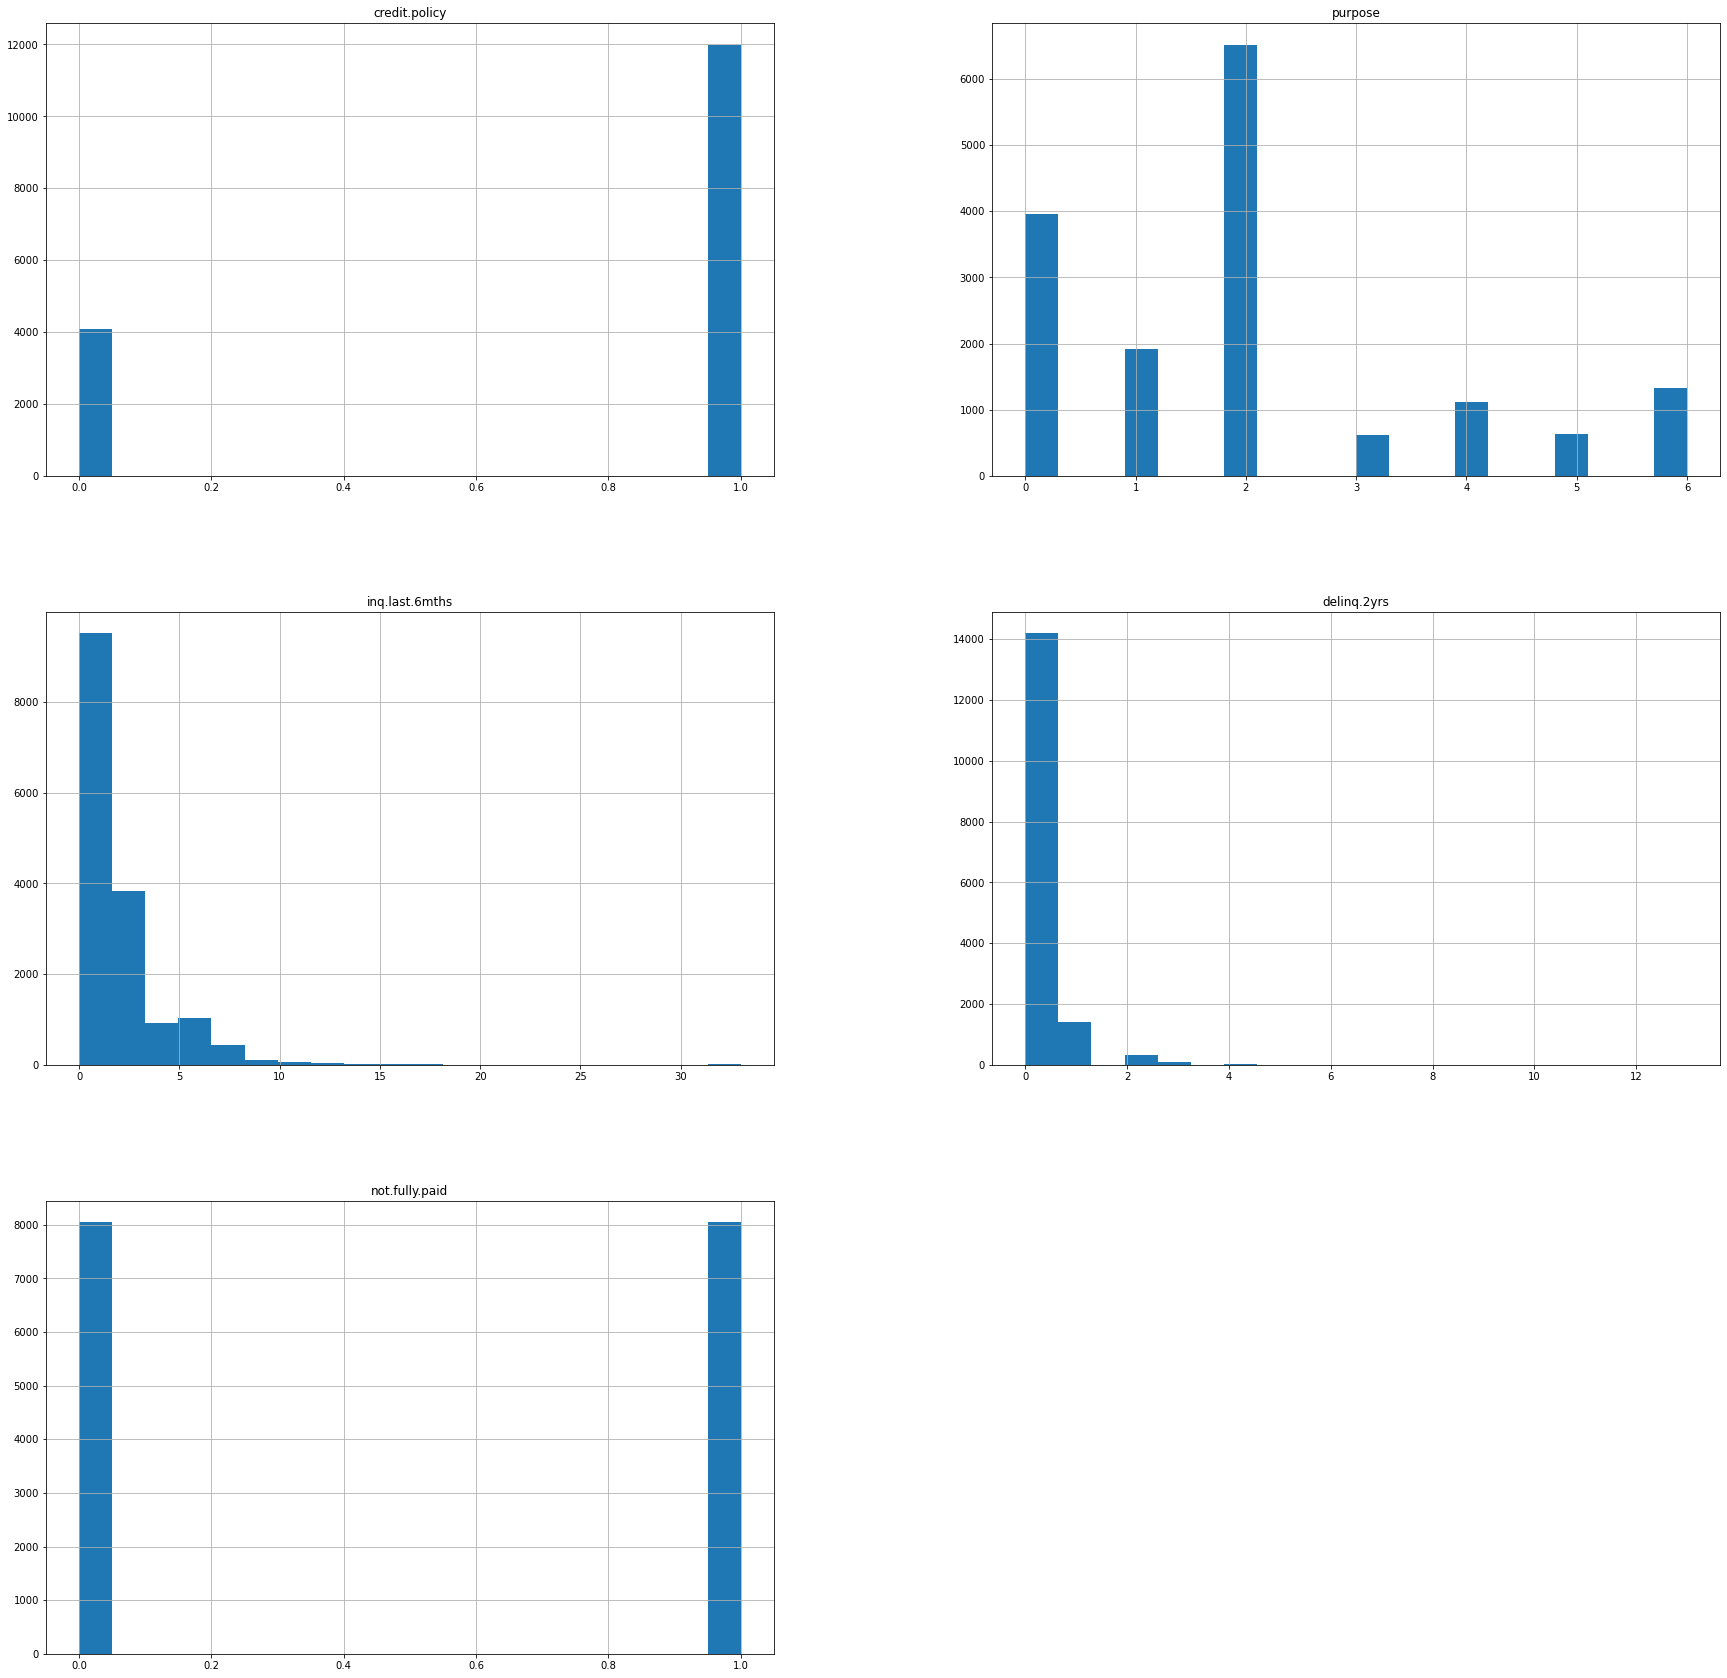

In [40]:
# Check the distribution of the categorical data
cat_data.hist(figsize = (30, 30), bins = 20, legend = False)
plt.rcParams["font.size"] = "20"
plt.show()

- It can be seen that most of the categorical data is positively skewed.
- Most clients satisfied the credit policy.
- Most clients decided to take the loan for purposes of loan consolidation.

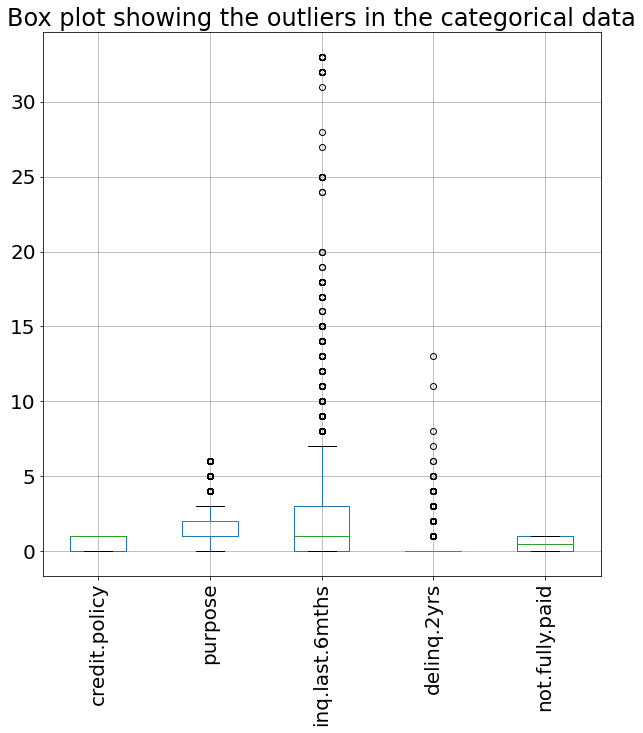

In [42]:
# Create plots showing the uncertainity in the categorical data and the outliers.
plt.figure(figsize = (10, 10))
cat_data.boxplot()
plt.xticks(rotation = 90)
plt.title("Box plot showing the outliers in the categorical data")
plt.show()

The graph shown above indicates that outliers exist in all variables of categorical data.

## DATA WRANGLING

In this section, data will be wrangled in the sense that all missing values will handled in both numerical and categorical data. Outliers in the numerical and categorical data will be eliminated so that the data can produce an improved result in the prediction model at a faster time.

***Handling missing values in the data frame***

In [44]:
# Convert the categorical feature in the data set into a numerical feature
le = preprocessing.LabelEncoder()
df["purpose"] = le.fit_transform(df["purpose"].astype(str))
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
4037,1,6,0.1695,356.27,10.839581,23.53,702,4410.000000,19230,44.4,3,0,0,0
679,1,1,0.1640,636.39,11.918391,24.03,672,4290.041667,28846,57.9,1,0,0,1
3921,1,6,0.1758,251.60,10.308953,13.16,712,2100.000000,12017,73.7,1,0,0,0
694,1,0,0.1071,782.44,11.156251,0.57,727,5040.041667,782,3.0,1,0,0,1
5404,1,2,0.0894,292.30,11.127263,17.81,752,9300.000000,38581,65.4,1,0,0,0


In [45]:
# Check for missing values in the data frame
df.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

There are no missing values in the given dataframe.

***Handling outliers and skewness in the numerical variable of our data set.***

In [46]:
# Detect outliers in combined data set
def detect_outlier(feature):
    outliers = []
    data = df[feature]
    mean = np.mean(data)
    std =np.std(data)
    
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(y)
    print(f"\nOutlier caps for {feature}")
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99),
                                                             len([i for i in data
                                                                  if i > data.quantile(.99)])))

In [47]:
# Determine what the upperbound should be for continuous features in dataframe.
for feat in num_data:
    detect_outlier(feat)


Outlier caps for int.rate
  --95p: 0.2 / 793 values exceed that
  --3sd: 0.2 / 47 values exceed that
  --99p: 0.2 / 134 values exceed that

Outlier caps for installment
  --95p: 804.2 / 801 values exceed that
  --3sd: 974.1 / 0 values exceed that
  --99p: 875.0 / 158 values exceed that

Outlier caps for log.annual.inc
  --95p: 11.9 / 804 values exceed that
  --3sd: 12.9 / 160 values exceed that
  --99p: 12.6 / 161 values exceed that

Outlier caps for dti
  --95p: 23.9 / 796 values exceed that
  --3sd: 33.8 / 0 values exceed that
  --99p: 26.9 / 155 values exceed that

Outlier caps for fico
  --95p: 777.0 / 669 values exceed that
  --3sd: 816.6 / 17 values exceed that
  --99p: 802.0 / 103 values exceed that

Outlier caps for days.with.cr.line
  --95p: 9120.0 / 801 values exceed that
  --3sd: 11963.1 / 243 values exceed that
  --99p: 12993.3 / 161 values exceed that

Outlier caps for revol.bal
  --95p: 62638.1 / 805 values exceed that
  --3sd: 149659.0 / 236 values exceed that
  --99p: 

In [48]:
# Capping features in df to remover outliers in numerical features

# Upper bounded outliers
for var in ['int.rate' ,'installment', 'log.annual.inc', 'fico', 'days.with.cr.line', 'revol.bal', 'not.fully.paid']:
    df[var].clip(upper=df[var].quantile(.95), inplace=True)
    
# Lower and Upper bounded outliers
for var in ['log.annual.inc']:
    df[var].clip(lower = df[var].quantile(.05), upper = df[var].quantile(0.95), inplace=True)

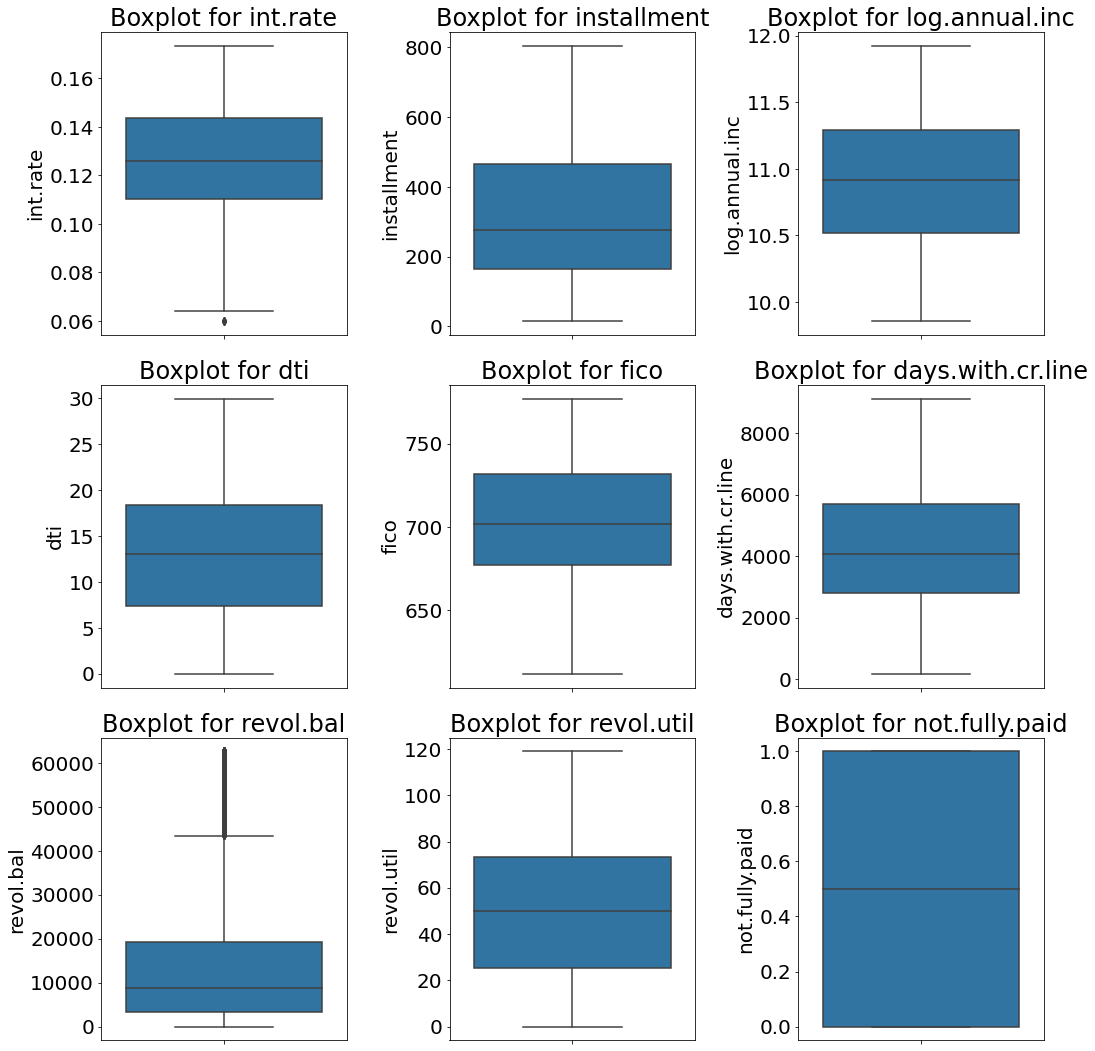

In [49]:
# Check for the presence of outliers in the numerical data of the dataframe again

# Define subplot grid
numerical_df = df[num_data_features]
plt.figure(figsize = (15, 15))

def num_plot(df, a, var):
    
    ax = plt.subplot(3, 3, a+1)
    sns.boxplot(y = df[var])
    ax.set_title(f"Boxplot for {var}")
    plt.tight_layout()

for i, col in enumerate(numerical_df):   
    num_plot(numerical_df, i, col)

After capping off outliers, we can see that outliers are now elimited in the numerical variables except ***revol.bal*** because it standard deviation is extremely high.

***Check the skewness in the numerical data of the dataframe***

In [50]:
# Check for skewness in the numerical features
vars_skewed = df[num_data_features].apply(lambda x: skew(x)).sort_values(ascending = False)
vars_skewed

revol.bal            1.655192
installment          0.788186
days.with.cr.line    0.492519
fico                 0.373699
not.fully.paid       0.000000
dti                 -0.006512
revol.util          -0.037321
log.annual.inc      -0.040023
int.rate            -0.086696
dtype: float64

Most of the numerical data is positively skewed. Skewness however, has to be correted in features with skewness higher than 0.3.

In [51]:
# Getting numerical features with skewness higher than 0.3.
high_skew = vars_skewed[abs(vars_skewed) > 0.3]
high_skew

revol.bal            1.655192
installment          0.788186
days.with.cr.line    0.492519
fico                 0.373699
dtype: float64

In [52]:
# Correct the skeness in the numerical features
for feat in high_skew.index:
    df[feat] = np.log1p(df[feat])

In [53]:
# Check for skewness in the numerical data again for the entire data set
vars_skewed = df[num_data_features].apply(lambda x: skew(x)).sort_values(ascending = False)
vars_skewed

fico                 0.285197
not.fully.paid       0.000000
dti                 -0.006512
revol.util          -0.037321
log.annual.inc      -0.040023
int.rate            -0.086696
installment         -0.571386
days.with.cr.line   -1.087876
revol.bal           -2.327846
dtype: float64

The skewness in some features reduces while others have remained the same and others have switched to being negatively skewed.

***Handle outliers and skewness in categorical features in our dataframe***

In [54]:
# Detect outliers in categorical data
for feat in cat_data:
    detect_outlier(feat)


Outlier caps for credit.policy
  --95p: 1.0 / 0 values exceed that
  --3sd: 2.1 / 0 values exceed that
  --99p: 1.0 / 0 values exceed that

Outlier caps for purpose
  --95p: 6.0 / 0 values exceed that
  --3sd: 7.3 / 0 values exceed that
  --99p: 6.0 / 0 values exceed that

Outlier caps for inq.last.6mths
  --95p: 6.0 / 776 values exceed that
  --3sd: 9.7 / 217 values exceed that
  --99p: 11.0 / 152 values exceed that

Outlier caps for delinq.2yrs
  --95p: 1.0 / 483 values exceed that
  --3sd: 1.8 / 483 values exceed that
  --99p: 2.0 / 159 values exceed that

Outlier caps for not.fully.paid
  --95p: 1.0 / 0 values exceed that
  --3sd: 2.0 / 0 values exceed that
  --99p: 1.0 / 0 values exceed that


In [55]:
# Capping features in combined_df to remove outliers in categorical features

# Upper bounded outliers
for cat in ['credit.policy', 'purpose', 'inq.last.6mths', 'delinq.2yrs']:
    df[cat].clip(upper=df[cat].quantile(.95), inplace=True)

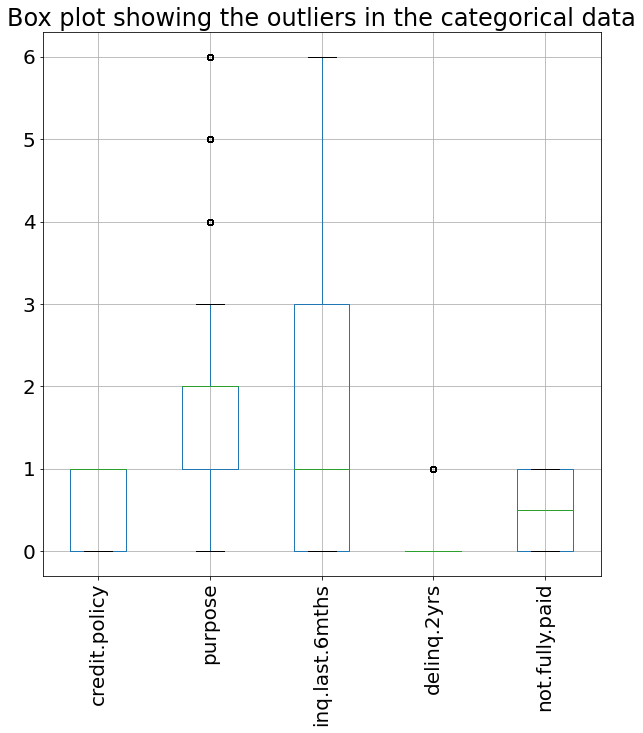

In [56]:
# Check for the presence of outliers in the numerical data of the dataframe again

# Define subplot grid
categorical_df = df[cat_data_features]

plt.figure(figsize = (10, 10))
categorical_df.boxplot()
plt.xticks(rotation = 90)
plt.title("Box plot showing the outliers in the categorical data")
plt.show()

We can see that the number of outliers in categorical data reduce significantly as compared to the previous case.

***Handle skeness in the categorical data of the dataframe***

In [57]:
# Identify the skewness in the categorical data
for cat in cat_data:
    cat_skewed = df[cat].skew()
    print(f"{cat}", cat_skewed)

credit.policy -1.1273025837435893
purpose 0.8658389522282369
inq.last.6mths 1.0422447940490056
delinq.2yrs 2.363448446595046
not.fully.paid 0.0


It can be seen that most of the data is positively skewed.

In [58]:
# Correct the skewness in categorical features of the dataframe if skewness is greater than 0.3.
for cat in cat_data:
    cat_skewed = df[cat].skew()
    if (cat_skewed) > 0.3:
        df[cat] = np.log1p(df[cat])

In [59]:
# Confirm the correction  of the skewness in the categorical data again
for cat in cat_data:
    cat_skewed = df[cat].skew()
    print(f"{cat}", cat_skewed)

credit.policy -1.1273025837435893
purpose -0.2229830165707196
inq.last.6mths 0.23064698419226032
delinq.2yrs 2.3634484465950463
not.fully.paid 0.0


The skewness in features such as ***purpose*** and ***inq.last.6mths*** has been reduced below 0.3 but other features reduced insignificantly. 

## FEATURE ENGINEERING

In [60]:
# Identify the correlations in the numerical data

# Independent variables
X_num = df[num_data_features]
X_num = X_num.drop(['not.fully.paid'], axis = 1)

# Dependent variable
Y = df[['not.fully.paid']]

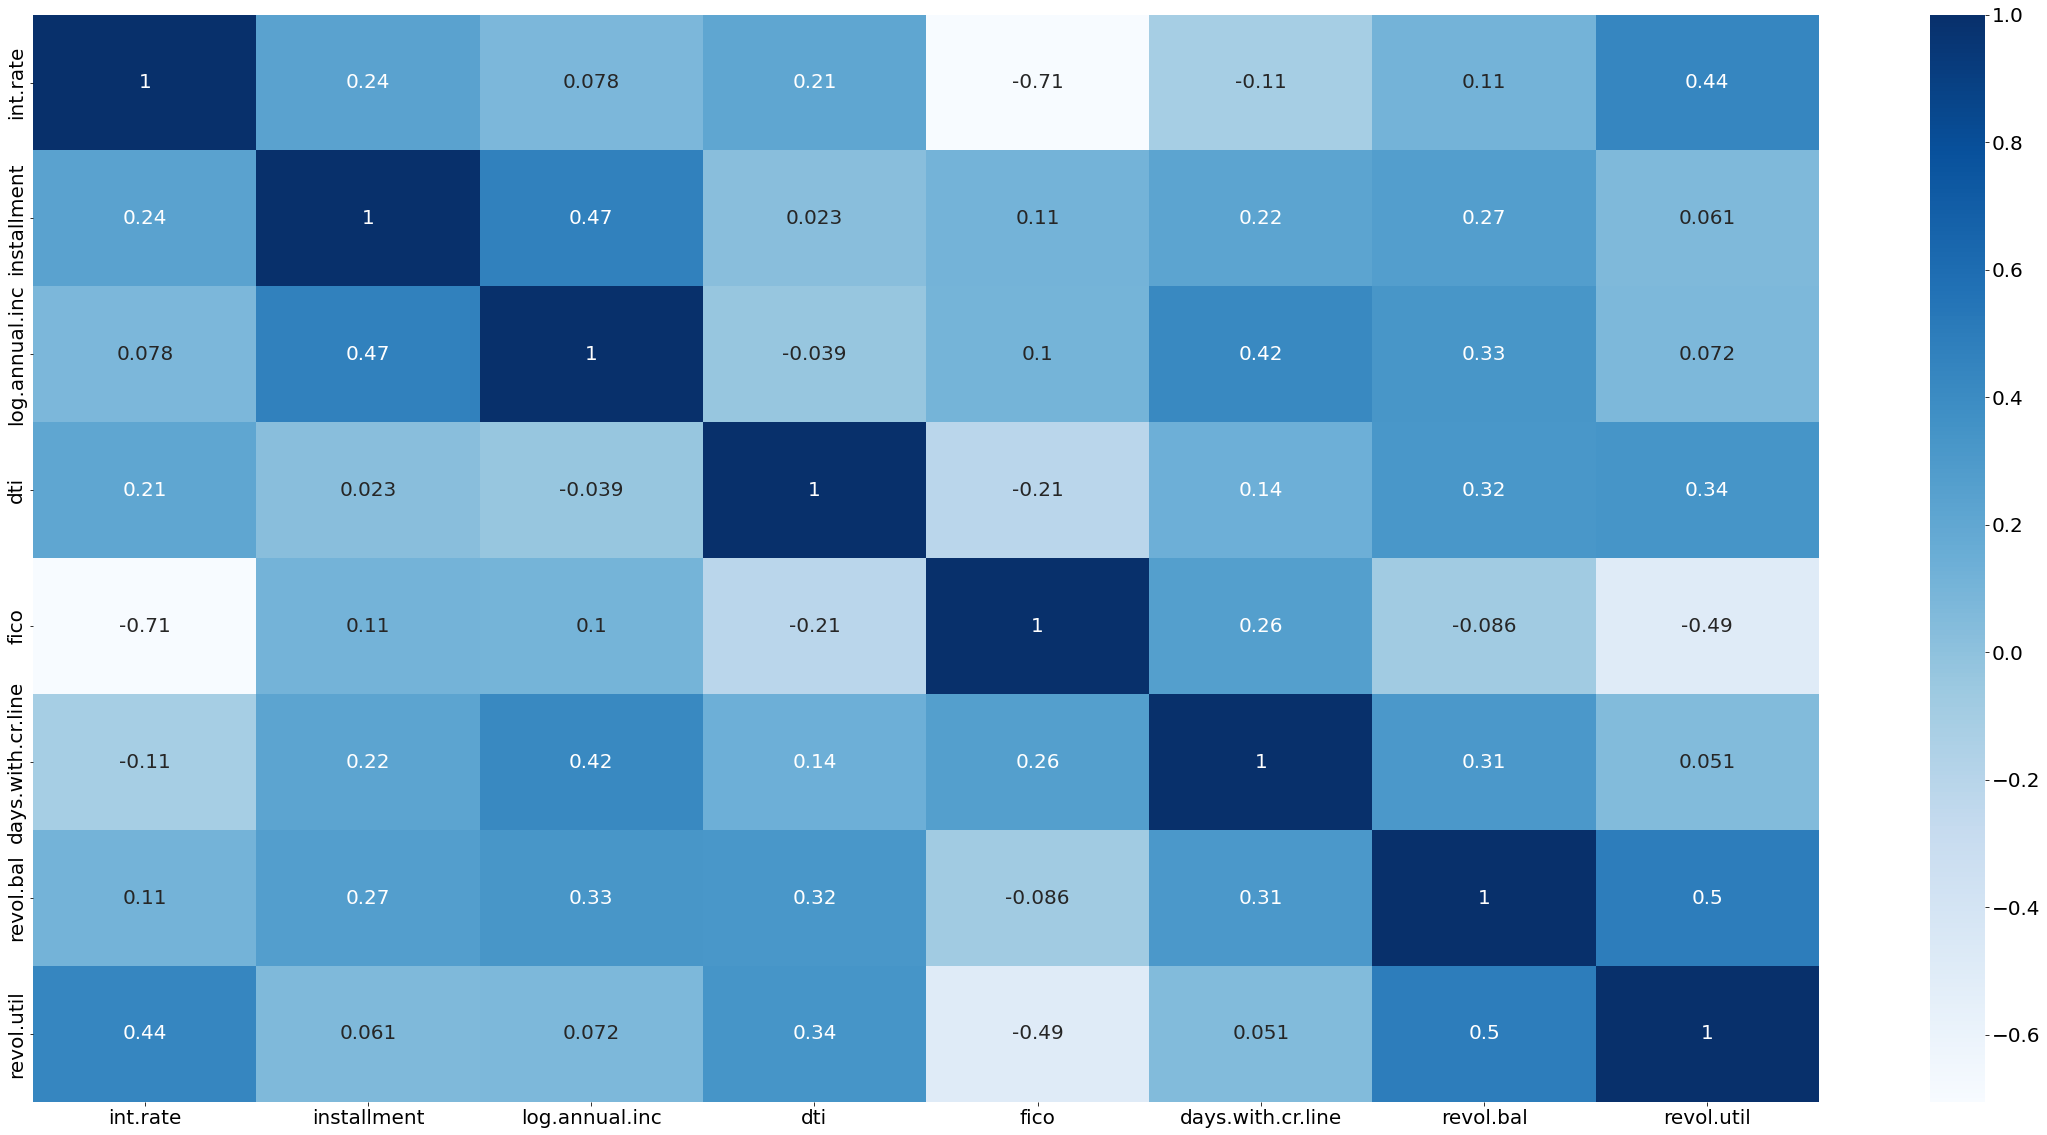

In [61]:
# Generate a correlation
matrix = X_num.corr()
plt.figure(figsize = [40, 20])
sns.heatmap(matrix, annot = True, cmap = "Blues");

Strong correlations among features is not highly encouragable because it results into a noisy signal in the prediction model which cannot give us clear information about the features that are contributing more to the predictions. As such, features with strong correlations among themselves will be eliminated. 

In [62]:
# Select strong correlations among features
cor_pairs = matrix.unstack()
sorted_pairs = cor_pairs.sort_values(kind = 'quicksort')
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.7]

print(strong_pairs)

fico               int.rate            -0.705555
int.rate           fico                -0.705555
                   int.rate             1.000000
days.with.cr.line  days.with.cr.line    1.000000
fico               fico                 1.000000
dti                dti                  1.000000
log.annual.inc     log.annual.inc       1.000000
installment        installment          1.000000
revol.bal          revol.bal            1.000000
revol.util         revol.util           1.000000
dtype: float64


In [63]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Get top pairs
def get_top_abs_correlations(df, n=10):
    corr_list = df.abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    corr_list = corr_list.drop(labels=labels_to_drop).sort_values(ascending=False)
    return corr_list[0:n]

In [64]:
# Get top 10 correlation pairs
print('Top 10 correlation pairs:')
get_top_abs_correlations(matrix, 5)

Top 10 correlation pairs:


int.rate     fico              0.705555
revol.bal    revol.util        0.498207
fico         revol.util        0.494045
installment  log.annual.inc    0.470828
int.rate     revol.util        0.436452
dtype: float64

In [65]:
# Feature Selection
Y = le.fit_transform(Y)
from sklearn.datasets import make_friedman1
from sklearn.svm import SVR
X_num, Y = make_friedman1(n_samples=9578, n_features=8, random_state=42)
estimator = SVR(kernel="linear")
rfe = RFE(estimator, n_features_to_select=5, step=1)
rfe = rfe.fit(X_num, Y.ravel())

D:\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
num_cols = df[num_data_features].drop(['not.fully.paid'], axis = 1)

In [67]:
num_cols = num_cols.columns
num_cols

Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
       'days.with.cr.line', 'revol.bal', 'revol.util'],
      dtype='object')

In [68]:
# Check the RFE ranking
X_num = pd.DataFrame(X_num, columns = [num_cols])
list(zip(X_num.columns, rfe.support_, rfe.ranking_))

[(('int.rate',), True, 1),
 (('installment',), True, 1),
 (('log.annual.inc',), True, 1),
 (('dti',), True, 1),
 (('fico',), True, 1),
 (('days.with.cr.line',), False, 2),
 (('revol.bal',), False, 3),
 (('revol.util',), False, 4)]

In [69]:
# Columns selected by RFE
cols = X_num.columns[rfe.support_]
cols

MultiIndex([(      'int.rate',),
            (   'installment',),
            ('log.annual.inc',),
            (           'dti',),
            (          'fico',)],
           )

In [70]:
# columns not selected by RFE
X_num.columns[~rfe.support_]

MultiIndex([('days.with.cr.line',),
            (        'revol.bal',),
            (       'revol.util',)],
           )

The factors that contribute most to wether someone will default or not are such as ***int.rate***, ***installment***, ***log.annual.inc***, ***dti*** and ***fico***. 

In [71]:
# Show the selected numerical features
num_vals = df[['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico']]
num_vals.head()

,int.rate,installment,log.annual.inc,dti,fico
4037,0.1695,5.878492,10.839581,23.53,6.555357
679,0.1640,6.457382,11.918391,24.03,6.511745
3921,0.1734,5.531807,10.308953,13.16,6.569481
694,0.1071,6.663694,11.156251,0.57,6.590301
5404,0.0894,5.681196,11.127263,17.81,6.624065


***Select the best features in categorical data***

In [80]:
# Collecting the categorical data
cat_vars = df[cat_data_features].drop(['not.fully.paid'], axis = 1)
cat_vars

,credit.policy,purpose,inq.last.6mths,delinq.2yrs
4037,1,1.945910,1.386294,0.0
679,1,0.693147,0.693147,0.0
3921,1,1.945910,0.693147,0.0
694,1,0.000000,0.693147,0.0
5404,1,1.098612,0.693147,0.0
...,...,...,...,...
9161,0,1.098612,1.791759,0.0
2464,1,1.098612,0.000000,0.0
4100,1,1.098612,0.693147,0.0
395,1,0.693147,0.693147,0.0


In [81]:
# Perform the chi test and determine the f score and the p value
f_p_values = chi2(cat_vars, df['not.fully.paid'])
f_p_values

(array([162.70187578,   9.55080275, 289.04643404,   1.14165418]),
 array([2.90637009e-37, 1.99861993e-03, 8.02289051e-65, 2.85303062e-01]))

Chi-square is used to find F-score and p-values for categorical features. So in this case the first array is for F score and the second array is for p-values.The higher the value of the F score is the more important the feature and the smaller the value of the p-value the more important will be the feature. A p-value less 0.05 indicates that the feature is important.

In [82]:
# Representing the p values in list form
p_values = pd.Series(f_p_values[1])
p_values.index = cat_vars.columns
p_values

credit.policy     2.906370e-37
purpose           1.998620e-03
inq.last.6mths    8.022891e-65
delinq.2yrs       2.853031e-01
dtype: float64

In [83]:
# Sorting the p values in ascending order
p_values.sort_values(ascending = True)

inq.last.6mths    8.022891e-65
credit.policy     2.906370e-37
purpose           1.998620e-03
delinq.2yrs       2.853031e-01
dtype: float64

Categorical features such as ***inq.last.6mths***, ***credit.policy***, and ***purpose*** have a p-value that is less than 0.05. These will therefore be taken into consideration for model training as they are seen to mostly influence wether a client will default or not.

## DATA TRAINING

In [94]:
# Divide the data into features and target variables
X = df[['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'inq.last.6mths', 'credit.policy', 'purpose']]
y = df['not.fully.paid']

In [95]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [96]:
# Scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [99]:
model  = keras.Sequential(
    [
        keras.layers.Dense(
        256, activation="relu", input_shape=[8]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 134,145
Trainable params: 134,145
Non-trai

In [100]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

In [101]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/1000
51/51 [==============================] - 4s 12ms/step - loss: 0.6518 - binary_accuracy: 0.6126 - val_loss: 0.6388 - val_binary_accuracy: 0.6131
Epoch 2/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.6419 - binary_accuracy: 0.6274 - val_loss: 0.6311 - val_binary_accuracy: 0.6224
Epoch 3/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.6372 - binary_accuracy: 0.6307 - val_loss: 0.6286 - val_binary_accuracy: 0.6255
Epoch 4/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.6331 - binary_accuracy: 0.6390 - val_loss: 0.6267 - val_binary_accuracy: 0.6333
Epoch 5/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.6299 - binary_accuracy: 0.6419 - val_loss: 0.6225 - val_binary_accuracy: 0.6504
Epoch 6/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.6256 - binary_accuracy: 0.6478 - val_loss: 0.6186 - val_binary_accuracy: 0.6454
Epoch 7/1000
51/51 [==============================] - 0s 7ms/st

51/51 [==============================] - 0s 7ms/step - loss: 0.3350 - binary_accuracy: 0.8511 - val_loss: 0.4005 - val_binary_accuracy: 0.8219
Epoch 54/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3281 - binary_accuracy: 0.8527 - val_loss: 0.3869 - val_binary_accuracy: 0.8313
Epoch 55/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3276 - binary_accuracy: 0.8536 - val_loss: 0.3921 - val_binary_accuracy: 0.8232
Epoch 56/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3146 - binary_accuracy: 0.8628 - val_loss: 0.4177 - val_binary_accuracy: 0.8204
Epoch 57/1000
51/51 [==============================] - 0s 8ms/step - loss: 0.3126 - binary_accuracy: 0.8629 - val_loss: 0.3833 - val_binary_accuracy: 0.8362
Epoch 58/1000
51/51 [==============================] - 0s 7ms/step - loss: 0.3068 - binary_accuracy: 0.8654 - val_loss: 0.3810 - val_binary_accuracy: 0.8431
Epoch 59/1000
51/51 [==============================] - 0s 7ms/step - los

In [102]:
predictions =(model.predict(X_test)>0.5).astype("int32")
              
predictions

101/101 [==============================] - 0s 2ms/step


array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [103]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
accuracy_score(y_test, predictions)

0.8781852082038534

In [104]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1641
           1       0.83      0.95      0.88      1577

    accuracy                           0.88      3218
   macro avg       0.89      0.88      0.88      3218
weighted avg       0.89      0.88      0.88      3218



It can be seen that our model has an accuracy of 87.82 which is quite good. 
Thank you for going through this notebook.